# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [ ]:
#restart the kernel once after install this package
#!pip install 'gym<0.25.0'
#!pip install 'gym[atari, accept-rom-license]'

In [1]:
# Watch for changes
%load_ext autoreload
%autoreload 2

# custom utilies for displaying animation, collecting rollouts and more
import numpy as np
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

# Monkey patch missing attributes for newer numpy versions
if not hasattr(np, "float_"):
    np.float_ = np.float64
    
if not hasattr(np, "int_"):
    np.int_ = np.int64

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



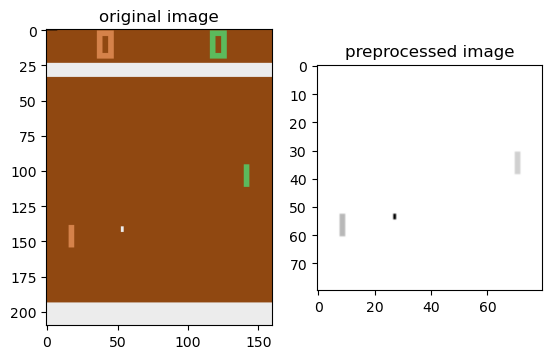

In [3]:
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _,_ , _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()


# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        # Assume the preprocessed Pong input is an 80x80 image with 2 channels (e.g., frame difference or stacked frames)
        # Conv layer 1: 2 input channels → 16 filters; kernel size=8, stride=4.
        # Output size: ((80-8)//4 + 1) = 19, so output: 16 x 19 x 19.
        self.conv1 = nn.Conv2d(2, 16, kernel_size=8, stride=4)
        
        # Conv layer 2: 16 → 32 filters; kernel size=4, stride=2.
        # Output size: ((19-4)//2 + 1) = 8, so output: 32 x 8 x 8.
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        
        # Conv layer 3: 32 → 64 filters; kernel size=3, stride=1.
        # Output size: ((8-3)//1 + 1) = 6, so output: 64 x 6 x 6.
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        
        # Flattened size = 64 * 6 * 6 = 2304.
        self.fc1 = nn.Linear(64 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Pass input through conv layers with ReLU activations.
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Flatten the tensor for the fully connected layers.
        x = x.view(x.size(0), -1)
        
        # Pass through a fully connected layer.
        x = F.relu(self.fc1(x))
        # Output a single probability (for moving right).
        out = self.sigmoid(self.fc2(x))
        return out

policy=Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

In [7]:
pong_utils.play(env, policy, time=100)# , preprocess=pong_utils.preprocess_single) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [8]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

In [9]:
print(prob)

[array([0.50936526, 0.49066332, 0.5093609 , 0.5093367 ], dtype=float32), array([0.49062786, 0.50937366, 0.5093703 , 0.509328  ], dtype=float32), array([0.50937146, 0.50936246, 0.50935984, 0.5093584 ], dtype=float32), array([0.5093039 , 0.4907344 , 0.5092656 , 0.50928396], dtype=float32), array([0.49051374, 0.49052826, 0.5094799 , 0.50950575], dtype=float32), array([0.5092141, 0.5092112, 0.5091913, 0.4907979], dtype=float32), array([0.50935894, 0.50935894, 0.49062455, 0.509364  ], dtype=float32), array([0.5091992, 0.4908008, 0.5092319, 0.5092335], dtype=float32), array([0.49063933, 0.4906538 , 0.49062717, 0.49062878], dtype=float32), array([0.49068412, 0.50933635, 0.50932205, 0.49067327], dtype=float32), array([0.49070454, 0.49068308, 0.49067596, 0.49069214], dtype=float32), array([0.50931185, 0.5093161 , 0.5092957 , 0.50928915], dtype=float32), array([0.49064142, 0.5093586 , 0.5093658 , 0.4906346 ], dtype=float32), array([0.49076396, 0.4908094 , 0.5092275 , 0.50921476], dtype=float32),

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(this is the same as policy_loss except the negative sign)

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

We implement Option 1.

Before we begin let us think how to calculate the **reward-to-go**:

In [ ]:
import numpy as np

# Example rewards and discount factor
rewards = [1, 2, 3]
discount_factor = 0.9

# Calculate reward-to-go
discounted_rewards = []
R = 0

# Iterate backwards over rewards
for r in reversed(rewards):
    R = r + discount_factor * R
    discounted_rewards.insert(0, R)

print("Original rewards:", rewards)
print("Discounted rewards (reward-to-go):", discounted_rewards)

# Expected output:
# For rewards = [1, 2, 3] and discount = 0.9, we expect:
# Step 2: R = 3
# Step 1: R = 2 + 0.9*3 = 4.7
# Step 0: R = 1 + 0.9*4.7 = 5.23
# Thus, discounted_rewards should be: [5.23, 4.7, 3]

Ok, let us use this in our surrogate function, which approximates the reward estimation so that we have a signal for the gradient ascent step.

In [10]:
# This surrogate function serves as an approximate objective function that guides gradient updates 
# without directly modifying rewards, keeping training more stable.
def surrogate_plain_reinforce(policy, old_probs, states, actions, rewards,
              discount=0.995, beta=0.01):
    """
    Compute the surrogate loss for the policy.  This is the objective function for the basic REINFORCE algorithm.
    The old_probs are the probabilities of the actions taken in the states under the old policy, but they aren't used here.
    """
    # Convert actions to a tensor
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    
    # Convert states to probabilities (new policy's probabilities)
    new_probs = pong_utils.states_to_prob(policy, states)

    # Choose probability corresponding to the taken action:
    # If the action equals pong_utils.RIGHT, use new_probs; otherwise use 1-new_probs.
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0 - new_probs)
    
    # Compute discounted cumulative rewards (returns)
    discounted_rewards = []
    R = 0

    # Iterate backwards over rewards to compute the return for each time step
    for r in reversed(rewards):
        R = r + discount * R
        discounted_rewards.insert(0, R)
        
    discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32, device=device)
    
    # Compute the policy gradient surrogate objective:
    # We want to maximize the expected log probability of taken actions weighted by the return.
    # So our loss (to minimize) is the negative of that expectation. (gradient ascent)
    policy_loss = -torch.mean(torch.log(new_probs + 1e-10) * discounted_rewards)
    
    # Compute the entropy of the new policy to encourage exploration.
    # Note: Entropy of a Bernoulli distribution is -[p log(p) + (1-p) log(1-p)]

    # This is a kind of regularization that discourages the policy from becoming too confident.
    entropy = -(new_probs * torch.log(new_probs + 1e-10) + 
                (1.0 - new_probs) * torch.log(1.0 - new_probs + 1e-10))
    
    entropy_reg = beta * torch.mean(entropy)
    
    # Total loss: We subtract the entropy bonus (since higher entropy is good)
    total_loss = policy_loss - entropy_reg
    return total_loss

# Example usage:
Lsur = surrogate_plain_reinforce(policy, prob, state, action, reward)
print(Lsur)


/tmp/ipykernel_327798/3360094054.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647327489/work/torch/csrc/utils/tensor_new.cpp:278.)
  actions = torch.tensor(actions, dtype=torch.int8, device=device)


tensor(-1.2902, device='cuda:0', grad_fn=<SubBackward0>)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [ ]:
from parallelEnv import parallelEnv
import numpy as np
import progressbar as pb
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 200
# episode = 800

# widget bar to display progress
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]

timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
beta = .01 # regularization via entropy
tmax = 320

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)

    # use your own surrogate function
    L = -surrogate_plain_reinforce(policy, old_probs, states, actions, rewards, beta=beta)

    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
        
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()
    

Episode: 20, score: -15.000000
[-14. -15. -16. -16. -14. -17. -15. -13.]


Episode: 40, score: -15.500000
[-16. -16. -16. -15. -17. -11. -16. -17.]


Episode: 60, score: -14.750000
[-16. -17. -17. -17.  -8. -17. -17.  -9.]


Episode: 80, score: -15.500000
[-17. -11. -17. -17. -17. -12. -16. -17.]


Episode: 100, score: -16.625000
[-17. -17. -17. -17. -16. -15. -17. -17.]


Episode: 120, score: -15.375000
[-17. -13. -17. -16. -16. -17. -10. -17.]


Episode: 140, score: -17.000000
[-17. -17. -17. -17. -17. -17. -17. -17.]


Episode: 160, score: -17.000000
[-17. -17. -17. -17. -17. -17. -17. -17.]


Episode: 180, score: -17.000000
[-17. -17. -17. -17. -17. -17. -17. -17.]


Episode: 200, score: -17.000000
[-17. -17. -17. -17. -17. -17. -17. -17.]


Training is unstable here. Score increases slightly but decreases soon after. May be a better surrogate function could yield better results. Let's try this later in a another notebook with more advanced REINFORCE implementations (PPO).

In [11]:
# play game after training!
pong_utils.play(env, policy, time=2000) 

In [ ]:
plt.plot(mean_rewards)

In [ ]:
# save your policy!
torch.save(policy, 'REINFORCE.policy')

# load your policy if needed
# policy = torch.load('REINFORCE.policy')

# try and test out the solution!
# policy = torch.load('PPO_solution.policy')